# SOEC Co-Electrolysis

This example shows a 1D isothermal SOEC (Solid oxide electrolyzer cell) model for
converting carbon dioxide and steam into syngas.

The operating parameters chosen here are not necessarily realistic. For example,
a utilization of 0.95 causes issues with the formation of solid carbon.

In [1]:
import gaspype as gp
from gaspype.constants import R, F
import numpy as np
import matplotlib.pyplot as plt

Calculate equilibrium compositions for fuel and air sides in counter flow
along the fuel flow direction:

In [2]:
utilization = 0.95
air_dilution = 0.2
t = 700 + 273.15  # K
p = 1e5  # Pa

fs = gp.fluid_system('H2, H2O, O2, CH4, CO, CO2')
feed_fuel = gp.fluid({'H2O': 2, 'CO2': 1}, fs)

o2_full_conv = np.sum(gp.elements(feed_fuel).get_n(['C' ,'O']) * [-1/2, 1/2])

feed_air = gp.fluid({'O2': 1, 'N2': 4}) * o2_full_conv * utilization * air_dilution

conversion = np.linspace(0, utilization, 128)
perm_oxygen = o2_full_conv * conversion * gp.fluid({'O2': 1})

fuel_side = gp.equilibrium(feed_fuel - perm_oxygen, t, p)
air_side  = gp.equilibrium(feed_air  + perm_oxygen, t, p)

Plot compositions of the fuel and air side:

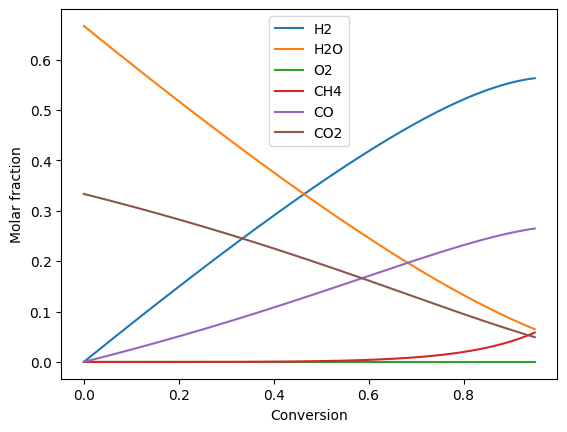

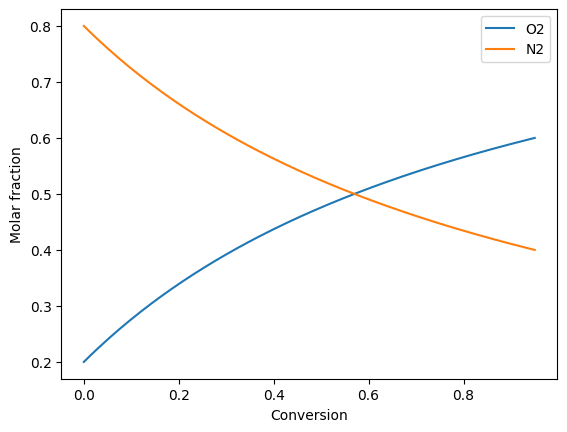

In [3]:
fig, ax = plt.subplots()
ax.set_xlabel("Conversion")
ax.set_ylabel("Molar fraction")
ax.plot(conversion, fuel_side.get_x(), '-')
ax.legend(fuel_side.species)

fig, ax = plt.subplots()
ax.set_xlabel("Conversion")
ax.set_ylabel("Molar fraction")
ax.plot(conversion, air_side.get_x(), '-')
ax.legend(air_side.species)

Calculation of the oxygen partial pressures:

In [4]:
o2_fuel_side = gp.oxygen_partial_pressure(fuel_side, t, p)
o2_air_side = air_side.get_x('O2') * p

Plot oxygen partial pressures:

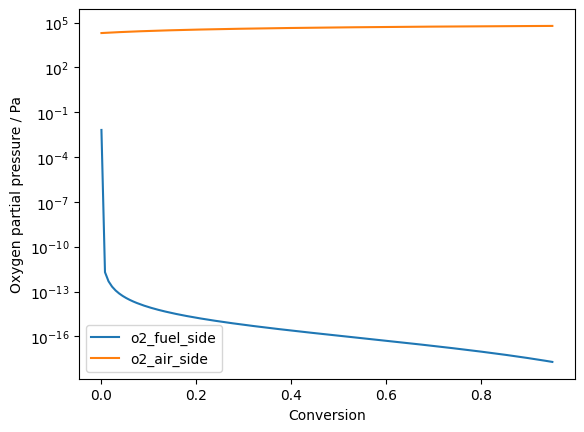

In [5]:
fig, ax = plt.subplots()
ax.set_xlabel("Conversion")
ax.set_ylabel("Oxygen partial pressure / Pa")
ax.set_yscale('log')
ax.plot(conversion, np.stack([o2_fuel_side, o2_air_side], axis=1), '-')
ax.legend(['o2_fuel_side', 'o2_air_side'])

The high oxygen partial pressure at the inlet is in reality lower.
The assumption that gas inter-diffusion in the flow direction is slower
than the gas velocity does not hold at this very high gradient. However
often the oxygen partial pressure is still to high to prevent oxidation of the
cell/electrode. This can be effectively prevented by recycling small amounts of
the hydrogen riche output gas.

Calculation of the local nernst potential between fuel and air side:

In [6]:
z_O2 = 4
nernst_voltage = R*t / (z_O2*F) * np.log(o2_air_side/o2_fuel_side)

Plot nernst potential:

0.3130521934494483


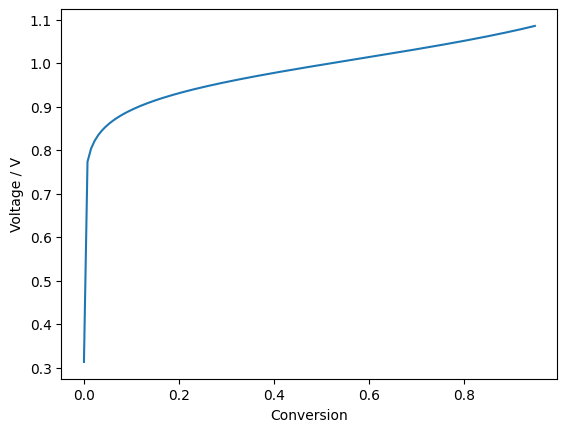

In [7]:
fig, ax = plt.subplots()
ax.set_xlabel("Conversion")
ax.set_ylabel("Voltage / V")
ax.plot(conversion, nernst_voltage, '-')
print(np.min(nernst_voltage))

The model uses between each node a constant conversion. Because
current density depends strongly on the position along the cell
the constant conversion does not relate to a constant distance.

![Alt text](../../media/soc_inverted.svg)

To calculate the local current density (**node_current**) as well
as the total cell current (**terminal_current**) the (relative)
physical distance between the nodes (**dz**) must be calculated:

In [8]:
cell_voltage = 1.3  # V
ASR = 0.2  # Ohm*cm²

node_current = (nernst_voltage - cell_voltage) / ASR  # A/cm² (Current density at each node)

current = (node_current[1:] + node_current[:-1]) / 2  # A/cm² (Average current density between the nodes)

dz = 1/current / np.sum(1/current)  # Relative distance between each node

terminal_current = np.sum(current * dz) # A/cm² (Total cell current per cell area)

print(f'Terminal current: {terminal_current:.2f} A/cm²')

Terminal current: -1.53 A/cm²


Plot the local current density:

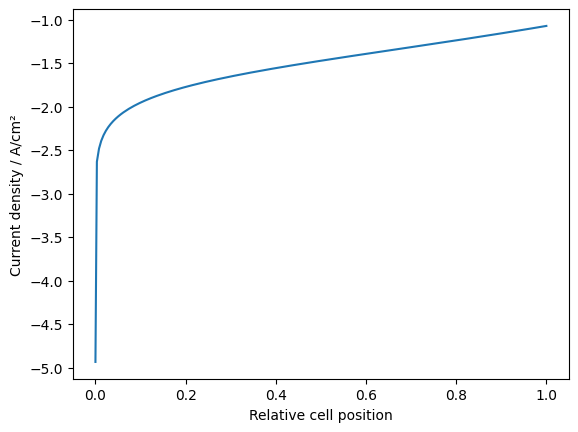

In [9]:
z_position = np.concatenate([[0], np.cumsum(dz)])  # Relative position of each node

fig, ax = plt.subplots()
ax.set_xlabel("Relative cell position")
ax.set_ylabel("Current density / A/cm²")
ax.plot(z_position, node_current, '-')